### Formulas and Discriptions

$$\text{Perplexity} = \exp\left(-\frac{1}{N} \sum_{i=1}^{N} \log P(w_i \mid w_{i-n+1}^{i-1})\right)$$


### initial test

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import softmax
from functools import partial
from tqdm.auto import tqdm
import os, random 
import math

NGRAM_RESULTS_DIR = os.path.join("..", "results", "ngram")
TOKENIZER_RESULTS_DIR = os.path.join("..", "results", "tokenizer")
os.makedirs(NGRAM_RESULTS_DIR, exist_ok=True)
os.makedirs(TOKENIZER_RESULTS_DIR, exist_ok=True)

In [4]:
# add parent directory to the path to allow imports
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from ngram_engine import NGramEngine, check_context_distribution, plot_ngram_probs
from bpe_hf import train_bytelevel_bpe, train_and_encode_tokenizer, load_tokenizer, SPECIAL_TOKENS
from ngram_engine import perplexity_over_n, plot_perplexity_and_n_grams_combinations

In [5]:
# testing
N = 3
interpolate = True
lambdas = softmax([7, 4, 2])
get_all_probs = True

model = NGramEngine(N)

example_text = """
<s> simple simple simple example of some simple example text for some simple example code </s>
"""


model.fit(example_text, lambdas, pad_token="<s>")

print("total ngram vocab size: ",model.total_vocab_size)
print("model vocab: ", model.vocab)
print("interpolation lambdas: ", model.lambdas)
display(model.counts)
prob, all_probs = model.get_n_gram_prob("of some simple", interpolate, verbose=True, get_all_probs=get_all_probs) 
print("ngram prob: ", prob, "\nall probs: ", all_probs)

generated_text = model.generate(list("of some simple".split(" ")), max_new_tokens=100, mode="argmax")
generated_text = model.generate("of some simple", max_new_tokens=100, mode="sample",
                                stop_tokens=["</s>"],)
print("Generated text: ", generated_text) 

total ngram vocab size:  9
model vocab:  ('code', 'example', 'some', 'simple', 'for', '<s>', 'of', 'text', '</s>')
interpolation lambdas:  [0.94649912 0.04712342 0.00637746]


{0: Counter({(): 16}),
 1: Counter({('simple',): 5,
          ('example',): 3,
          ('some',): 2,
          ('<s>',): 1,
          ('of',): 1,
          ('text',): 1,
          ('for',): 1,
          ('code',): 1,
          ('</s>',): 1}),
 2: Counter({('simple', 'example'): 3,
          ('simple', 'simple'): 2,
          ('some', 'simple'): 2,
          ('<s>', 'simple'): 1,
          ('example', 'of'): 1,
          ('of', 'some'): 1,
          ('example', 'text'): 1,
          ('text', 'for'): 1,
          ('for', 'some'): 1,
          ('example', 'code'): 1,
          ('code', '</s>'): 1}),
 3: Counter({('some', 'simple', 'example'): 2,
          ('<s>', 'simple', 'simple'): 1,
          ('simple', 'simple', 'simple'): 1,
          ('simple', 'simple', 'example'): 1,
          ('simple', 'example', 'of'): 1,
          ('example', 'of', 'some'): 1,
          ('of', 'some', 'simple'): 1,
          ('simple', 'example', 'text'): 1,
          ('example', 'text', 'for'): 1,
        

Query: ('of', 'some', 'simple')
Prefix:('of', 'some')
N=3, Num: 2, Denom: 10, Prob: 0.2
Query: ('some', 'simple')
Prefix:('some',)
N=2, Num: 3, Denom: 11, Prob: 0.2727272727272727
Query: ('simple',)
Prefix:()
N=1, Num: 6, Denom: 25, Prob: 0.24
ngram prob:  0.2412871224675459 
all probs:  [0.24       0.27272727 0.2       ]
Generated text:  ['of', 'some', 'simple', '<s>', '</s>']


### Tokenizer and data preparation

In [6]:
data_dir = "../data/"
# without nl
# train_file = "Shakespeare_clean_train.txt"
# val_file = "Shakespeare_clean_valid.txt"
# test_file = "Shakespeare_clean_test.txt"
# with nl
train_file = "Shakespeare_clean_w_nl_train.txt"
val_file = "Shakespeare_clean_w_nl_valid.txt"
test_file = "Shakespeare_clean_w_nl_test.txt"

train_file = os.path.join(data_dir, train_file)
test_file = os.path.join(data_dir, test_file)
val_file = os.path.join(data_dir, val_file)

with open(train_file, "r", encoding="utf-8") as f:
    train_text = f.read().strip()

with open(val_file, "r", encoding="utf-8") as f:
    val_text = f.read().strip()

with open(test_file, "r", encoding="utf-8") as f:
    test_text = f.read().strip()

In [5]:
N_MERGES = 1200
MIN_FREQ = 2
SPECIAL_TOKENS = SPECIAL_TOKENS.copy()
PAD_TOKEN = SPECIAL_TOKENS.get("pad", "<pad>")
BOS_TOKEN = SPECIAL_TOKENS.get("bos", "<bos>")
EOS_TOKEN = SPECIAL_TOKENS.get("eos", "<eos>")

bpe_tokenizer = train_bytelevel_bpe(files=[train_file],
                                merges=N_MERGES, 
                                min_frequency=MIN_FREQ,
                                special_tokens=SPECIAL_TOKENS,
                                save_filename=f"bpe_shakespeare_{N_MERGES}",)
# bind encode to bpe_tokenizer.encode with add_special_tokens=False
encode = partial(bpe_tokenizer.encode, add_special_tokens=False)
decode = bpe_tokenizer.decode
vocab_size = bpe_tokenizer.get_vocab_size()
print("BPE tokenizer vocab: ", bpe_tokenizer.get_vocab())
print("vocab size: ", vocab_size)

PAD_TOKEN_ID = bpe_tokenizer.token_to_id(PAD_TOKEN) 
BOS_TOKEN_ID = bpe_tokenizer.token_to_id(BOS_TOKEN)
EOS_TOKEN_ID = bpe_tokenizer.token_to_id(EOS_TOKEN)

train_ids = encode(train_text).ids
test_ids = encode(test_text).ids
val_ids = encode(val_text).ids

print("train text charachters length: ", len(train_text))
print("train text words count: ", len(train_text.split()))
print("train ids length: ", len(train_ids))
print("train text first 100 chars: ", train_text[:100])
print("train ids first 100 ids: ", train_ids[:100])
print("train ids first 100 individual tokens: ", [bpe_tokenizer.id_to_token(i) for i in train_ids[:100]]) 


BPE tokenizer vocab:  {'£': 100, 'le': 322, 'Ġper': 879, 'Ġfather': 861, '>': 33, 'j': 77, 'Ġey': 649, 'ram': 1281, 'all': 793, 'à': 160, 'lp': 1184, 'uck': 1200, 'k': 78, 'ĠROM': 775, 'ĠWhen': 794, 'ONIUS': 886, 'ount': 897, 'ERC': 1175, 'Ġbeing': 1151, 'ild': 1448, 'Ġnight': 617, 'ì': 172, 'Ġsir': 604, 'Ġconf': 1126, 'Ġworld': 881, 'ng': 715, 'ô': 180, 'Ġcour': 904, 'Ġcl': 826, 'Ġfall': 1090, 'AM': 531, 'Ġapp': 1185, 'ink': 550, 'IL': 739, 'Ġhonour': 936, 'DEMON': 946, 'õ': 181, 'ach': 907, 'ĠANT': 568, 'gh': 333, 'av': 1392, 'Ġass': 1261, 'Ġdre': 1104, 'Ġdisc': 1458, 'Ġmist': 1409, 'Ġway': 926, 'ck': 409, 'ANIO': 1030, 'Y': 60, 'ost': 888, 'Ġever': 999, 'ient': 1384, 'li': 977, 'Ġdie': 1099, 'Ġappe': 1379, 'd': 71, 'Ð': 144, 'Ġthus': 921, 'Ġplace': 1069, 'Ġyet': 664, 'ĠHere': 986, 'ice': 625, 'iz': 1132, 'h': 75, 'Ġsha': 406, 'DU': 1327, 'Ġf': 280, 'ite': 849, 'TIA': 661, 'Ġwith': 352, 'ither': 795, 'out': 459, 'ĠOPHEL': 1331, 'as': 349, 'EUS': 1309, 'Ġwort': 1164, 'Ġlet': 526, 'Ĵ':

### inspect ngram model

In [6]:
TRAIN_TEXT = train_ids
N = 4
INTERPOLATE = True

lambdaBias = 0.8
weights = np.linspace(1 - lambdaBias, lambdaBias, N) * 8
lambdas = softmax(weights)

model = NGramEngine(N)
model.fit(TRAIN_TEXT, lambdas, pad_token=BOS_TOKEN_ID)

print(f"N = {N}\nlambdaBias = {lambdaBias:.2f}, lambdas = {lambdas}")
print("prob of non-existened n-gram and (n-1)-gram :", 1 / model.total_vocab_size) 
print("vocab size: ", model.total_vocab_size)
print("num all text tokens: ", len(TRAIN_TEXT))

context = "romeo and juliet are"
context_ids = encode(context).ids
print("context for next token probs: ", context)

probs, tokens, all_probs = model.get_next_token_probs(context_ids, interpolate=INTERPOLATE, get_all_probs=True)
df = pd.DataFrame({'token_ids': tokens, 'prob': probs})
df['token'] = df['token_ids'].apply(lambda x: decode([int(x)]))

for i in range(N):
    df[f'{i+1}-gram prob'] = all_probs[:,i]

df = df.sort_values('prob', ascending=False).reset_index(drop=True)
display(df.head(10))

# generate text
context = "romeo and juliet are"
context_ids = encode(context).ids
print("context for text generation: ", context)
generated_text = model.generate(context_ids, max_new_tokens=100, mode="sample")
print("Generated text: ", decode(generated_text))

N = 4
lambdaBias = 0.80, lambdas = [0.00657912 0.0325866  0.16140249 0.79943178]
prob of non-existened n-gram and (n-1)-gram : 0.0008237232289950577
vocab size:  1214
num all text tokens:  364449
context for next token probs:  romeo and juliet are


,token_ids,prob,token,1-gram prob,2-gram prob,3-gram prob,4-gram prob
0,202,0.001925,\n,0.127300,0.009086,0.000824,0.000824
1,337,0.001393,not,0.004173,0.017604,0.000824,0.000824
2,297,0.001386,you,0.006057,0.017036,0.000824,0.000824
3,15,0.001308,",",0.041987,0.007382,0.000824,0.000824
4,273,0.001259,the,0.012014,0.011925,0.000824,0.000824
5,17,0.001176,.,0.019127,0.007950,0.000824,0.000824
6,541,0.001168,they,0.000916,0.011357,0.000824,0.000824
7,264,0.001116,a,0.007127,0.008518,0.000824,0.000824
8,438,0.001098,all,0.001603,0.009086,0.000824,0.000824
9,300,0.001067,p,0.002494,0.007950,0.000824,0.000824


context for text generation:  romeo and juliet are
Generated text:   romeo and juliet are like thingftALaint ladyil seemraw un St and Marwell h too thingsac Are high spirit ROMEO his off CHARMIANilectionaltnd world RODERIGOles elessen Ifenterst B Cassius So Who live LADYewCAingsin MARKRAT thus by ifurnves po bidaster backeUCation fearient meet noblehat cont Q preMIAN DU likeINCE thingsposeEUS letterDERIocondMON kn daughter pl afswpeain caop forone G speakwn onceUTIOimty This


In [7]:
# get all n-gram probabilities for different n-grams
print_top_k = 10
n_gram_probs_dict = {}
for n in range(1, N + 1):
    n_gram_probs_dict[n] = oneGram_probs = {key: model.get_n_gram_prob(key, interpolate=INTERPOLATE, n=n) for key in model.get_n_grams(TRAIN_TEXT, n)}
    n_gram_probs_dict[n] = {tuple([decode([int(i)]) for i in k]): v for k, v in n_gram_probs_dict[n].items()}
    print(f"num all {n}-grams: ", model.counts[n].total())
    print(f"Distinct {n}-grams: ", len(n_gram_probs_dict[n]))
    print(f"top {print_top_k} {n}-grams (decoded): ", [(decode(i[0]), i[1]) for i in model.counts[n].most_common(print_top_k)])

num all 1-grams:  364449
Distinct 1-grams:  1214
top 10 1-grams (decoded):  [('\n', 46548), (',', 15352), ('.', 6993), (' the', 4392), ('s', 4241), ('T', 3558), ('A', 3377), (' and', 3244), (' to', 3033), (';', 2993)]
num all 2-grams:  364448
Distinct 2-grams:  59185
top 10 2-grams (decoded):  [('\n\n', 19105), ('.\n', 5408), (',\n', 4204), ('\nT', 3323), ('\nA', 2716), ('\nI', 2036), ('\nW', 2009), ('\nS', 1581), ('\nH', 1474), ('?\n', 1425)]
num all 3-grams:  364447
Distinct 3-grams:  179478
top 10 3-grams (decoded):  [('\n\n\n', 12412), ('.\n\n', 3981), ('\nAnd', 1274), ('?\n\n', 1077), (',\nA', 816), ('\nThe', 799), (',\nT', 767), ('\nTo', 630), ('!\n\n', 618), ('\n\nM', 587)]
num all 4-grams:  364446
Distinct 4-grams:  252782
top 10 4-grams (decoded):  [('\n\n\n\n', 5781), ('.\n\n\n', 3971), ('?\n\n\n', 1077), ('!\n\n\n', 618), (',\nAnd', 598), ('\n\n\nM', 585), ('\n\n\nE', 567), ('\n\n\nS', 493), ('\n\n\nB', 446), ('\n\n\nH', 431)]


sum of probabilities for 1-gram:  1.0
sum of probabilities for 2-gram:  202.37060413233735
sum of probabilities for 3-gram:  838.332618183833
sum of probabilities for 4-gram:  1046.6905986799215


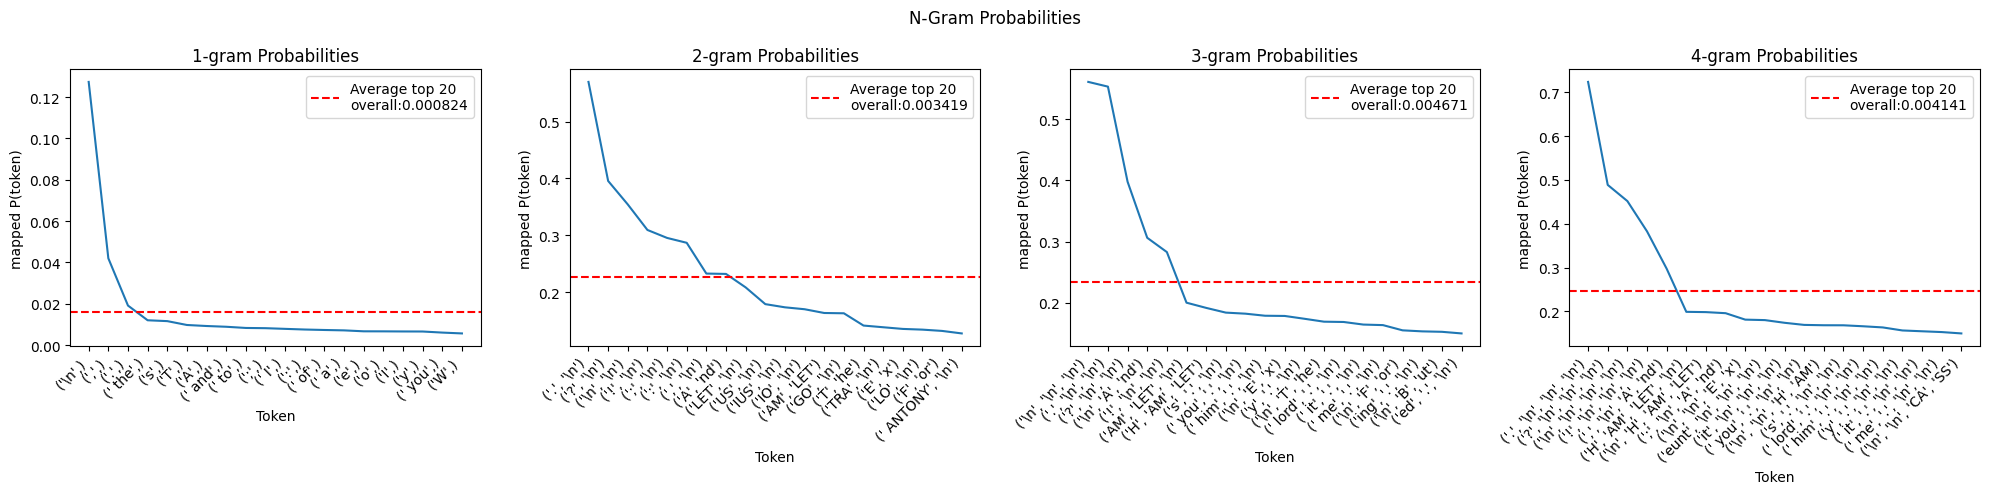

In [8]:
n_rows = int(np.floor(N*0.4))
n_cols = N // n_rows + N%2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*5))   
axs = axs.flatten()
plt.suptitle('N-Gram Probabilities')

plot_top_n = 20
for n in range(1, N + 1):
    ax = plot_ngram_probs(n_gram_probs_dict[n], top_n=plot_top_n,
                        title=f'{n}-gram Probabilities', ax=axs[n-1])
    
plt.legend()
plt.tight_layout()
plt.show()

#### ensure margilizing over conditional probabilities sums to 1

In [9]:
n = 3
model_test = NGramEngine(n)
lambdas = softmax(np.linspace(1, n , n))
# lambdas = softmax(np.array([0.1, 0.7, 0.2]))

model_test.fit(TRAIN_TEXT, lambdas, pad_token=BOS_TOKEN_ID)

print("lambdas: ", model_test.lambdas, "\nsum lambdas: ", np.sum(model_test.lambdas))

out1 = check_context_distribution(model_test, encode("the").ids, interpolate=True)
out2 = check_context_distribution(model_test, encode("to be").ids, interpolate=True)
out3 = check_context_distribution(model_test, encode("romeo and").ids, interpolate=False)

lambdas:  [0.09003057 0.24472847 0.66524096] 
sum lambdas:  0.9999999999999999

Context: [273]
Sum of probs = 0.876589
Top 10 tokens:
  21         0.000750
  25         0.000750
  27         0.000750
  486        0.000750
  713        0.000750
  777        0.000750
  994        0.000750
  1111       0.000750
  1150       0.000750
  1258       0.000750

Context: [298, 317]
Sum of probs = 1.000000
Top 10 tokens:
  202        0.016329
  264        0.009544
  15         0.007418
  280        0.005825
  265        0.005521
  862        0.005237
  451        0.005101
  68         0.005098
  17         0.004465
  973        0.004310

Context: [571, 363, 82, 299]
Sum of probs = 1.000000
Top 10 tokens:
  368        0.004072
  319        0.002443
  273        0.001629
  345        0.001629
  355        0.001629
  370        0.001629
  912        0.001629
  1026       0.001629
  1062       0.001629
  1397       0.001629


### interactive playground

In [10]:
import numpy as np
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
from scipy.special import softmax

TRAIN_TEXT = train_ids
CASHED_MODEL = {}

train_output = widgets.Output()
generate_output = widgets.Output()

def explore_train_model(N, train_context, lambdaBias, lambdaScale):
    global TRAIN_TEXT
    with train_output:
        train_output.clear_output(wait=True)

        weights = np.linspace(1 - lambdaBias, lambdaBias, N) * lambdaScale
        lambdas = softmax(weights)

        model = NGramEngine(N)
        model.fit(TRAIN_TEXT, lambdas, pad_token=BOS_TOKEN_ID)
        
        CASHED_MODEL["model"] = model

        print(f"lambdas (1-gram → {N}-gram):", np.round(lambdas, 3))
        print("total vocab size:", model.total_vocab_size)
        print("-" * 40)

        print("next token probabilities:")
        # for context in ["<s>", "example text for some simple"]:
        # for context in ["blabla. <s>", "example text for some simple"]:
        context = train_context
        context_ids = encode(context).ids
        # context = ' '.join([str(token) for token in context])

        next_token_probs, tokens, all_probs = model.get_next_token_probs(context_ids, interpolate=True, get_all_probs=True)
        df = pd.DataFrame({'token_ids': tokens, 'prob': next_token_probs})
        df['token'] = df['token_ids'].apply(lambda x: decode([int(x)]))
        # replace spaces by <space> in each token that has spaces in it
        df['token'] = df['token'].apply(lambda x: x.replace(' ', '<space>'))

        for i in range(N):
            df[f'{i+1}-gram prob'] = all_probs[:,i]

        df = df.sort_values('prob', ascending=False).reset_index(drop=True)

        print(f"context: {context}")
        display(df.head(10))


def explore_generate_text(b):
    with generate_output:
        model = CASHED_MODEL.get("model")
        if model is None:
            print("No model cached. Please run the training first.")
            return
        
        generate_output.clear_output(wait=True)
            
        max_pred = max_pred_slider.value
        gen_mode = gen_mode_slider.value
        temperature = temperature_slider.value
        top_k = top_k_slider.value
        top_p = top_p_slider.value
        repeat_penalty = repetition_penalty_slider.value
        context = gen_context.value

        context_ids = encode(context).ids
        # context = ' '.join([str(token) for token in context])

        print("-" * 40)
        print("Generated text:")
        gen_text_ids = model.generate(context_ids,
                                      max_len=max_pred,
                                      mode=gen_mode,
                                      temperature=temperature,
                                      top_k=top_k,
                                      top_p=top_p,
                                      repetition_penalty=repeat_penalty)

        print("Generated text IDs:", type(gen_text_ids))
        gen_text = decode(gen_text_ids)
        
        print(f"Context: {context}")
        print(gen_text)
        
        output_box.value = gen_text
        display(output_box)

n_slider = widgets.IntSlider(
    value=3, min=1, max=8, step=1,
    description='N', continuous_update=False
)

lambdaBias_slider = widgets.FloatSlider(
    value=0.8, min=0.0, max=1.0, step=0.05,
    description='lambdaBias', continuous_update=False
)

lambdaScale_slider = widgets.FloatSlider(
    value=8, min=1, max=20, step=1,
    description='lambdaScale', continuous_update=False
)

train_context_input = widgets.Text(
    value="and here comes",
    description="Next-word context:",
    layout=widgets.Layout(width="100%")
)

max_pred_slider = widgets.IntSlider(
    value=80, min=1, max=500, step=10,
    description='Max Predictions', continuous_update=False
)   

gen_mode_slider = widgets.ToggleButtons(
    options=['argmax', 'sample'],
    description='Mode',
    value='argmax',
    style={'description_width': 'initial'}
)

temperature_slider = widgets.FloatSlider(
    value=0.8, min=0.0, max=8.0, step=0.1,
    description='Temperature', continuous_update=False
)

top_k_slider = widgets.IntSlider(
    value=50, min=0, max=100, step=1,
    description='Top K', continuous_update=False
)

top_p_slider = widgets.FloatSlider(
    value=0.0, min=0.0, max=1.0, step=0.01,
    description='Top P', continuous_update=False
)

repetition_penalty_slider = widgets.FloatSlider(
    value=1.0, min=0.0, max=1.0, step=0.05,
    description='Repeat Penalty', continuous_update=False
)

gen_context = widgets.Text(
    value="and here comes",
    description='Context:',
    layout=widgets.Layout(width='100%')
)

output_box = widgets.Textarea(
        value="",
        layout=widgets.Layout(
            width='100%',
            height='300%',
            padding='10px',
            font_family='monospace',
            overflow='auto',
        ),
        style={
            'description_width': 'initial',
            'font_family': 'monospace',
        },
        disabled=True
    )

generate_button = widgets.Button(description='Generate Text', button_style='info')
generate_button.on_click(explore_generate_text)

prompt_box = widgets.VBox([gen_context, gen_mode_slider,
                            max_pred_slider, temperature_slider, top_k_slider, top_p_slider, repetition_penalty_slider,
                            generate_button, output_box])

complete_box = widgets.VBox([
    widgets.HTML("<h3>## Model Configuration</h3>"),
    lambdaBias_slider,
    lambdaScale_slider,
    n_slider,
    train_context_input,
    train_output,
    widgets.HTML("<h3>## Text Generation</h3>"),
    prompt_box
])

# Launch both areas
train_ui = widgets.interactive_output(
    explore_train_model,
    {'lambdaBias': lambdaBias_slider, 'lambdaScale': lambdaScale_slider,
     'N': n_slider, 'train_context': train_context_input}
)

display(complete_box)

display(train_ui)


Output()

### n-gram and tokenizer analyses

#### Perplexity over n

,n,ppl_val,bpt_val,nats_per_tok_val,ppl_train,bpt_train,nats_per_tok_train,num_n_grams
0,1,306.468119,8.259593,5.725114,305.799952,8.256444,5.722931,1214
1,2,88.647221,6.470003,4.484665,80.839086,6.336981,4.392461,59185
2,3,225.786319,7.818814,5.419589,171.887012,7.425317,5.146837,179478
3,4,417.337283,8.705070,6.033895,285.586480,8.157784,5.654545,252782
4,5,572.544432,9.161244,6.350090,369.391012,8.529005,5.911856,292740
5,6,682.680531,9.415067,6.526027,431.008860,8.751574,6.066129,312521
6,7,763.336961,9.576176,6.637700,476.027339,8.894901,6.165475,326303
7,8,827.949848,9.693400,6.718953,512.254250,9.000716,6.238821,336183
8,9,883.257270,9.786690,6.783617,543.692604,9.086647,6.298384,343794
9,10,928.268835,9.858399,6.833321,570.115321,9.155110,6.345839,350484


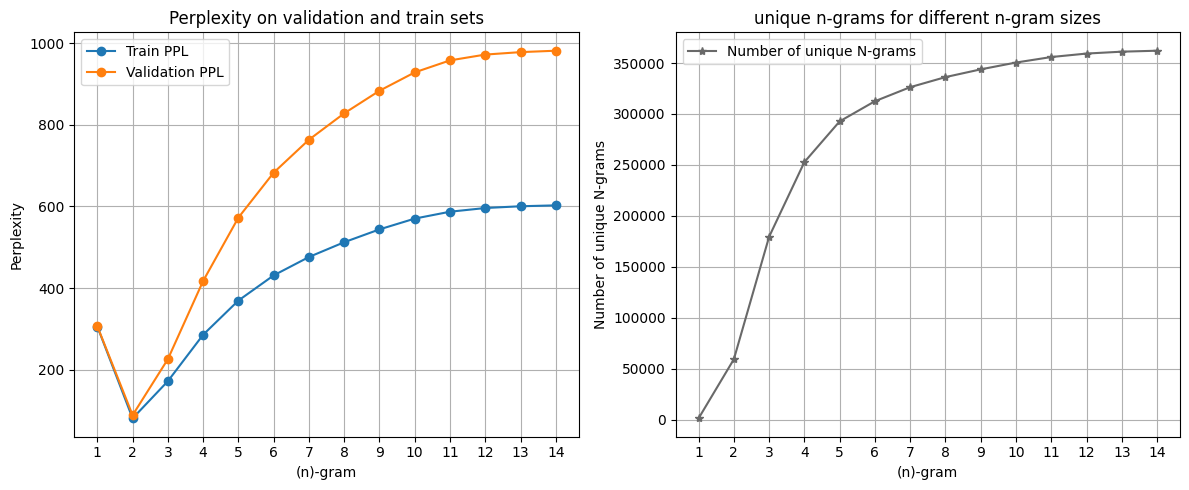

In [11]:
n_range = 15
TRAIN_TEXT = train_ids
VAL_TEXT = val_ids

ppl_results = perplexity_over_n(n_range, train_ids=TRAIN_TEXT, val_ids=VAL_TEXT ,verbose=False)
ppl_results = pd.DataFrame(ppl_results, index=None)
display(ppl_results)
plot_perplexity_and_n_grams_combinations(ppl_results, save_path=os.path.join(NGRAM_RESULTS_DIR, "ppl_over_n_grams.png"))

#### Tokenizer statistics

##### Heaps' law and corpus statistics

In [12]:
from bpe_hf import fit_tokenizer_params, plot_heaps_and_metrics,\
                _np_softmax, avg_token_chr_length, compression_ratio_agnostic,\
                heaps_curve, fit_heaps_law, plot_heaps, vocab_utilization

#### Tokenizer parameters search

In [13]:
n_merges_grid = list(range(10, 201, 20)) +\
                list(range(300, 2001, 100)) +\
                list(range(2500, 15501, 2000))  

df_tokenizer_search = fit_tokenizer_params(
    train_text_path=train_file,
    val_text_path=val_file,
    merges_grid=n_merges_grid,
    tokenizer_trainer=train_bytelevel_bpe,
    special_tokens=SPECIAL_TOKENS,
    min_frequency=2,
    target_tokens=None,
    heaps_step=200,
    verbose=False,
    plot_heaps=False,
    csv_log_path=os.path.join(TOKENIZER_RESULTS_DIR, "tokenizer_search_results.csv")
    )
display(df_tokenizer_search.head(10))

,merges,vocab_size,K,beta,R2,util_now,compression_ratio,chars_per_token,tokens_per_1k_chars,N_star,...,train_beta,train_R2,train_util_now,train_compression_ratio,train_chars_per_token,train_tokens_per_1k_chars,train_N_star,train_V_end,train_V_hat_star,train_util_star
0,10,270,55.143348,0.021254,0.678431,0.259259,0.000084,1.108080,902.462157,475760,...,0.012193,0.830415,0.281481,0.000011,1.107017,903.328883,3991720,76,72.965562,0.270243
1,30,290,72.916372,0.019171,0.589162,0.310345,0.000109,1.273120,785.471755,414085,...,0.009496,0.834313,0.331034,0.000014,1.270102,787.338478,3479170,96,92.950277,0.320518
2,50,310,91.771216,0.016695,0.543501,0.354839,0.000135,1.389473,719.697257,379410,...,0.008037,0.823700,0.374194,0.000017,1.385157,721.939849,3190180,116,113.020842,0.364583
3,70,330,103.977613,0.021007,0.525907,0.393939,0.000161,1.464999,682.594180,359850,...,0.007611,0.797073,0.412121,0.000020,1.456972,686.355202,3032935,136,133.292608,0.403917
4,90,350,116.317495,0.024254,0.470804,0.428571,0.000188,1.540494,649.142608,342215,...,0.006590,0.797664,0.445714,0.000023,1.531575,652.922673,2885200,156,153.284897,0.437957
5,110,370,127.446827,0.026629,0.461870,0.456757,0.000214,1.595388,626.806783,330440,...,0.009280,0.862861,0.475676,0.000027,1.585654,630.654688,2786800,176,174.613944,0.471930
6,130,390,134.355183,0.032615,0.478843,0.484615,0.000241,1.642280,608.909670,321005,...,0.008614,0.840825,0.502564,0.000030,1.632208,612.667180,2707315,196,194.764658,0.499397
7,150,410,138.032624,0.040054,0.492510,0.509756,0.000269,1.692582,590.813384,311465,...,0.007786,0.841127,0.526829,0.000033,1.681309,594.774718,2628250,216,214.755220,0.523793
8,170,430,143.279056,0.045559,0.498921,0.532558,0.000297,1.728771,578.445692,304945,...,0.008636,0.846145,0.548837,0.000037,1.719172,581.675304,2570365,236,235.623766,0.547962
9,190,450,150.319075,0.048530,0.502121,0.551111,0.000324,1.765387,566.447893,298620,...,0.008944,0.844027,0.568889,0.000040,1.757039,569.139379,2514970,256,256.246139,0.569436


/home/mj/Documents/Uni/wise25/building_gpt/Project/GPT_from_scratch/bpe_hf.py:489: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


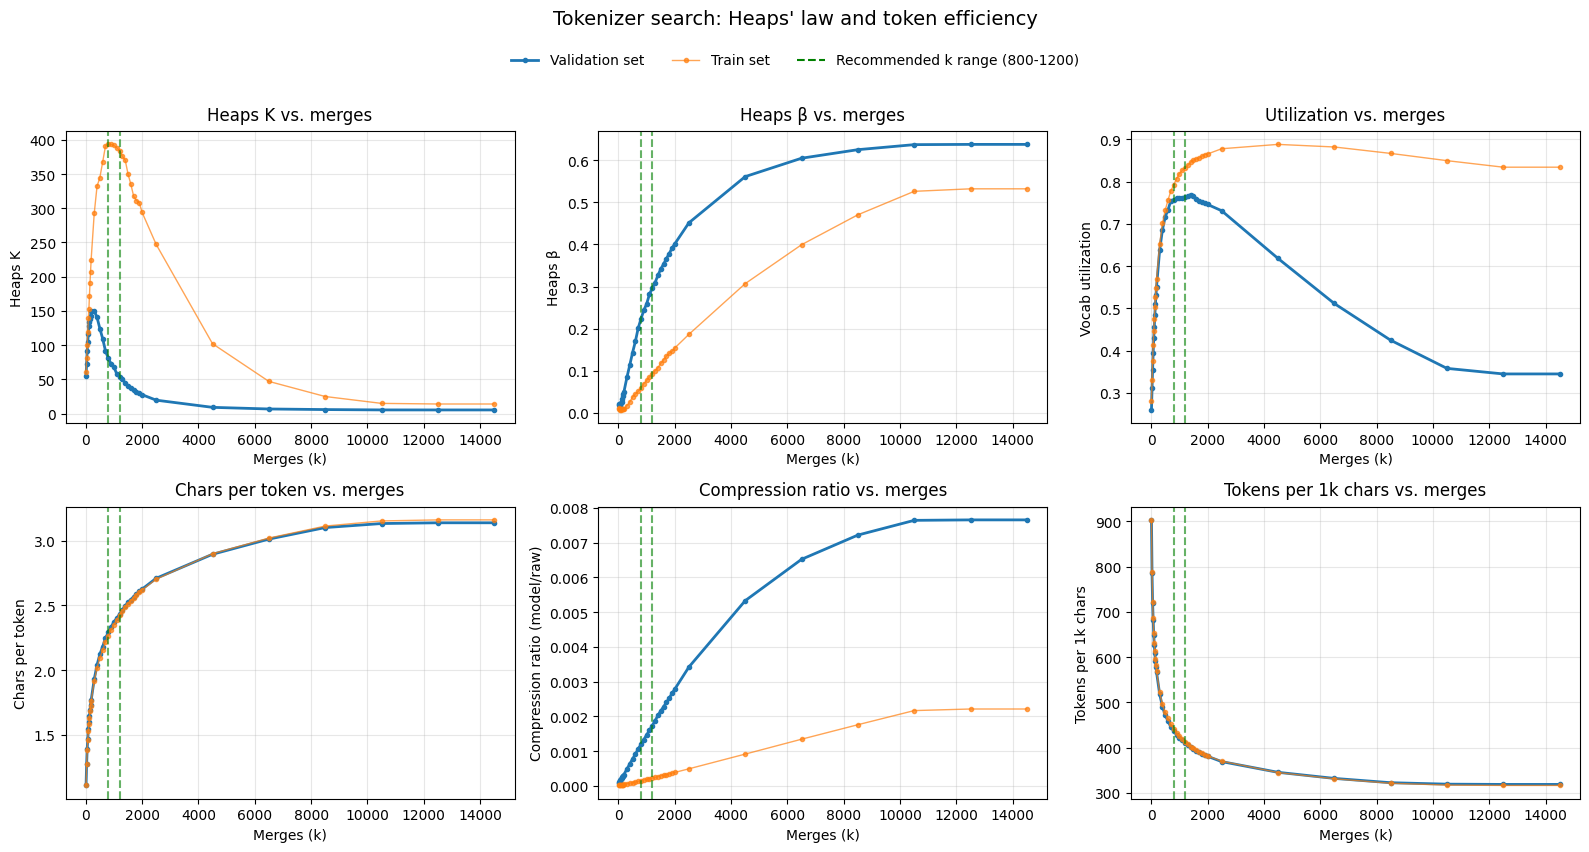

(<Figure size 1600x800 with 6 Axes>,
 array([[<Axes: title={'center': 'Heaps K vs. merges'}, xlabel='Merges (k)', ylabel='Heaps K'>,
         <Axes: title={'center': 'Heaps β vs. merges'}, xlabel='Merges (k)', ylabel='Heaps β'>,
         <Axes: title={'center': 'Utilization vs. merges'}, xlabel='Merges (k)', ylabel='Vocab utilization'>],
        [<Axes: title={'center': 'Chars per token vs. merges'}, xlabel='Merges (k)', ylabel='Chars per token'>,
         <Axes: title={'center': 'Compression ratio vs. merges'}, xlabel='Merges (k)', ylabel='Compression ratio (model/raw)'>,
         <Axes: title={'center': 'Tokens per 1k chars vs. merges'}, xlabel='Merges (k)', ylabel='Tokens per 1k chars'>]],
       dtype=object))

In [14]:
recommended_k_range = [800, 1200]
plot_heaps_and_metrics(
    df_tokenizer_search,
    recommended_k_range=recommended_k_range,
    suptitle="Tokenizer search: Heaps' law and token efficiency",
    save_path=os.path.join(TOKENIZER_RESULTS_DIR, "tokenizer_search_results.png")
)

In [ ]:
# exponentiated gradient for fitting λ
def set_py_seed(seed: int = 1337):
    random.seed(seed)
    np.random.seed(seed)

def _component_probs_matrix(model, ids, n: int, k_smoothing: float = 1.0, eps: float = 1e-12):
    """
    Build a matrix P of shape (T, n) with per-order component probabilities p_m(t)
    for t = n-1 .. len(ids)-1. Returns (P, start_index).
    """
    ids = list(ids)
    T = len(ids) - (n - 1)
    if T <= 0:
        return np.zeros((0, n), dtype=np.float64), (n - 1)

    P = np.zeros((T, n), dtype=np.float64)
    for t in range(n - 1, len(ids)):
        ctx = ids[t - n + 1 : t]
        tok = ids[t]
        # m = 1..n. For each m, query = last (m-1) of ctx plus tok
        for m in range(1, n + 1):
            prefix = ctx[-(m - 1):] if m > 1 else []
            query = tuple(prefix + [tok])
            p = model._n_gram_prob(query, m, k_smoothing=k_smoothing)
            P[t - (n - 1), m - 1] = max(p, eps)  # clamp to eps for stability
    return P, (n - 1)

def _loss_and_grad_bpt(lam: np.ndarray, P: np.ndarray, eps: float = 1e-12):
    """
    Compute (bits-per-token loss, gradient wrt lam) for mixture:
        L = - (1/T) sum_t log( sum_m lam_m * P[t,m] )
    grad_k = - (1/T) sum_t ( P[t,k] / sum_j lam_j * P[t,j] )
    Returns (bpt, grad) where bpt = nats/log(2).
    """
    mix = P @ lam  # shape (T,)
    mix = np.clip(mix, eps, None)
    nats = -np.mean(np.log(mix))
    bpt = nats / math.log(2.0)
    # gradient in nats
    # avg over t of ( - P[:,k] / mix )
    grad_nats = - (P / mix[:, None]).mean(axis=0)  # shape (n,)
    grad_bpt = grad_nats / math.log(2.0)
    return bpt, grad_bpt

def fit_lambdas_exponentiated_gradient(
    model,
    val_ids,
    n: int,
    *,
    k_smoothing: float = 1.0,
    max_iters: int = 500,
    eta: float = 0.5,             # initial step size in mirror space
    tol_rel: float = 1e-6,
    backtrack: bool = True,
    backtrack_factor: float = 0.5,
    min_lambda: float = 1e-12,
    verbose: bool = False,
):
    """
    Solve for lambda via Exponentiated Gradient to minimize BPT on val_ids.
    Returns lam (shape (n,)) and final bpt.
    """
    # precompute component probabilities on validation stream
    P, _ = _component_probs_matrix(model, val_ids, n=n, k_smoothing=k_smoothing)
    if P.shape[0] == 0:
        # degenerate stream → uniform weights
        return np.ones(n) / n, float("inf")

    # initialize with uniform
    lam = np.ones(n, dtype=np.float64) / n
    bpt, grad = _loss_and_grad_bpt(lam, P)

    for it in range(max_iters):
        old_bpt = bpt
        # mirror (EG) step: lam_new ∝ lam * exp(-eta * grad)
        step = eta
        while True:
            lam_prop = lam * np.exp(-step * grad)
            lam_prop = np.clip(lam_prop, min_lambda, None)
            lam_prop /= lam_prop.sum()

            bpt_prop, grad_prop = _loss_and_grad_bpt(lam_prop, P)

            # Armijo-like acceptance
            if not backtrack or (bpt_prop <= bpt - 1e-12):
                lam, bpt, grad = lam_prop, bpt_prop, grad_prop
                break
            step *= backtrack_factor
            if step < 1e-8:
                # give up shrinking; accept anyway to avoid stall
                lam, bpt, grad = lam_prop, bpt_prop, grad_prop
                break

        # convergence check (relative change)
        if abs(old_bpt - bpt) / max(1e-12, bpt) < tol_rel:
            if verbose:
                print(f"[EG] converged in {it+1} iters. bpt={bpt:.6f}")
            break

    return lam, bpt

def fit_ngram_hparams(
    *,
    train_text_path: str,
    val_text_path: str,
    n_grid=(2, 3, 4, 5),
    merges_grid=(500, 1000, 2000),
    tokenizer_trainer=None,
    tok_min_frequency: int = 2,
    tok_save_filename: str = "bpe_",
    log_every: int = 1,
    seed: int = 1337,
    special_tokens: dict | None = SPECIAL_TOKENS,
    verbose: bool = True,
):
    assert tokenizer_trainer is not None, "pass tokenizer_trainer=train_bytelevel_bpe (or compatible)."
    set_py_seed(seed)

    rows = []
    total = len(merges_grid) * len(n_grid)
    pbar = tqdm(total=total, desc="Hyperparam search")

    for merges in merges_grid:
        # initialize tokenizer and encode train/val
        tok_info = train_and_encode_tokenizer(
            tokenizer_trainer=train_bytelevel_bpe,
            train_text_path=train_text_path,
            other_texts_paths={"val":val_text_path},
            merges=merges,
            min_frequency=tok_min_frequency,
            special_tokens=special_tokens,
            save_filename=tok_save_filename,
        )
        train_ids = tok_info["train_ids"]
        val_ids   = tok_info["other_texts_ids"]["val"]
        pad_id    = tok_info["pad_id"]
        vocab_sz  = tok_info["vocab_size"]
        chars_per_token_val       = (len(val_text) / max(1, len(val_ids))) if len(val_ids) > 0 else float("inf")
        tokens_per_1k_chars_val   = (len(val_ids) / max(1, len(val_text) / 1000.0)) if len(val_text) > 0 else float("inf")
        for n in n_grid:
            # fit n-gram counts on train ids
            model = NGramEngine(n)
            model.fit(train_ids, pad_token=pad_id)

            # === Rigorous lambda optimization on validation set ===
            best_lam, _ = fit_lambdas_exponentiated_gradient(
                model, val_ids, n=n,
                k_smoothing=1.0,
                max_iters=500,
                eta=0.5,
                tol_rel=1e-7,
                backtrack=True,
                backtrack_factor=0.5,
                min_lambda=1e-12,
                verbose=False
            )

            # get metrics on val and train (using the final λ)
            model.lambdas = best_lam
            val_metrics   = model.fit_metrics(val_ids,   n=n, interpolate=True)
            train_metrics = model.fit_metrics(train_ids, n=n, interpolate=True)

            row = {
                "merges": merges,
                "n": n,
                "vocab_size": vocab_sz,
                "chars_per_token_val":       chars_per_token_val,
                "tokens_per_1k_chars_val":   tokens_per_1k_chars_val,
                "val_bpt":   val_metrics["bpt"],
                "val_ppl":   val_metrics["ppl"],
                "train_bpt": train_metrics["bpt"],
                "train_ppl": train_metrics["ppl"],
                "best_lambdas": best_lam.tolist(),
                "effective_tokens_val":   val_metrics["effective_tokens"],
                "effective_tokens_train": train_metrics["effective_tokens"],
            }
            rows.append(row)

            if verbose and (len(rows) % max(1, log_every) == 0):
                print(f"[k={merges:>5}, n={n}] "
                      f"val bpt={row['val_bpt']:.3f}, ppl={row['val_ppl']:.1f}, "
                      f"train bpt={row['train_bpt']:.3f} , ppl={row['train_ppl']:.1f} "
                      f"λ={np.array2string(best_lam, precision=4)}")

            pbar.update(1)

    pbar.close()
    df = pd.DataFrame(rows).sort_values(["merges", "n"]).reset_index(drop=True)
    return df


In [31]:
df_ngram_fit_results = fit_ngram_hparams(
    train_text_path=train_file,
    val_text_path=val_file,
    n_grid=np.arange(2,10),
    merges_grid=[10, 50, 100, 200, 500, 800, 1000, 1200, 2000, 5000, 10000],
    tokenizer_trainer=train_bytelevel_bpe,   
    tok_min_frequency=2,
    tok_save_filename="bpe_shakespeare_",
    verbose=True
)

Hyperparam search:   0%|          | 0/88 [00:00<?, ?it/s]

[k=   10, n=2] val bpt=3.812, ppl=14.0, train bpt=3.816 | λ=[3.8815e-06 1.0000e+00]
[k=   10, n=3] val bpt=3.063, ppl=8.4, train bpt=3.047 | λ=[4.8610e-13 2.9181e-05 9.9997e-01]
[k=   10, n=4] val bpt=2.909, ppl=7.5, train bpt=2.869 | λ=[4.8610e-13 8.7159e-06 3.7731e-01 6.2268e-01]
[k=   10, n=5] val bpt=2.909, ppl=7.5, train bpt=2.869 | λ=[4.8610e-13 2.6494e-08 3.7743e-01 6.2254e-01 2.8541e-05]
[k=   10, n=6] val bpt=2.909, ppl=7.5, train bpt=2.869 | λ=[4.8610e-13 2.8605e-08 3.7742e-01 6.2255e-01 2.7577e-05 4.8610e-13]
[k=   10, n=7] val bpt=2.909, ppl=7.5, train bpt=2.869 | λ=[4.8610e-13 3.1082e-08 3.7742e-01 6.2255e-01 2.8263e-05 4.8610e-13
 4.8610e-13]
[k=   10, n=8] val bpt=2.909, ppl=7.5, train bpt=2.869 | λ=[4.8610e-13 3.0064e-08 3.7743e-01 6.2255e-01 2.7452e-05 4.8610e-13
 4.8610e-13 4.8610e-13]
[k=   10, n=9] val bpt=2.909, ppl=7.5, train bpt=2.869 | λ=[4.8610e-13 3.2870e-08 3.7742e-01 6.2256e-01 2.8755e-05 4.8610e-13
 4.8610e-13 4.8610e-13 4.8610e-13]
[k=   50, n=2] val bpt=4

In [32]:
# save to csv
df_ngram_fit_results.to_csv(os.path.join(NGRAM_RESULTS_DIR, "ngram_hparams_fit_results.csv"), index=False)
display(df_ngram_fit_results.head(10))

,merges,n,vocab_size,chars_per_token_val,tokens_per_1k_chars_val,val_bpt,val_ppl,train_bpt,train_ppl,best_lambdas,effective_tokens_val,effective_tokens_train
0,10,2,270,1.108080,902.462157,3.811584,14.041102,3.816462,14.088660,"[3.881454758916814e-06, 0.9999961185452411]",95151,798344
1,10,3,270,1.108080,902.462157,3.062986,8.357008,3.047281,8.266527,"[4.860967534646988e-13, 2.9181230532587253e-05...",95150,798343
2,10,4,270,1.108080,902.462157,2.909471,7.513428,2.868671,7.303921,"[4.860967558479646e-13, 8.715898061822253e-06,...",95149,798342
3,10,5,270,1.108080,902.462157,2.909459,7.513366,2.868678,7.303954,"[4.860967537432918e-13, 2.6494389046227012e-08...",95148,798341
4,10,6,270,1.108080,902.462157,2.909451,7.513322,2.868673,7.303929,"[4.860967549232687e-13, 2.8604567221274213e-08...",95147,798340
5,10,7,270,1.108080,902.462157,2.909446,7.513297,2.868672,7.303924,"[4.860967540660682e-13, 3.108209909829307e-08,...",95146,798339
6,10,8,270,1.108080,902.462157,2.909433,7.513230,2.868671,7.303922,"[4.860967550781637e-13, 3.006354504068416e-08,...",95145,798338
7,10,9,270,1.108080,902.462157,2.909445,7.513290,2.868669,7.303912,"[4.860967534604595e-13, 3.2870330404346935e-08...",95144,798337
8,50,2,310,1.389473,719.697257,4.352024,20.421606,4.358753,20.517076,"[1.67774524167134e-06, 0.9999983222547583]",75881,638036
9,50,3,310,1.389473,719.697257,3.677968,12.799080,3.618042,12.278324,"[4.860967456525495e-13, 0.03110037894745576, 0...",75880,638035


#### load from available results

In [ ]:
from_hps_file = os.path.join(NGRAM_RESULTS_DIR, "ngram_hparams_fit_results.csv")

df_ngram_fit_results = pd.read_csv(from_hps_file)
# convert lambdas from string to list of floats
df_ngram_fit_results["best_lambdas"] = df_ngram_fit_results["best_lambdas"].apply(lambda x: [float(i) for i in x.strip("[]").split(",")])

In [35]:
def plot_parameter_search_results(df, save_path=None, returns=False):

    fig, axs = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle("N-gram Hyperparameter Search Results", fontsize=16)
    cmap = plt.get_cmap("plasma")

    # heatmap all weights of each n
    ax_hm_lambdas = axs[0, 0]
    max_n = df["n"].max()
    weights = np.array([row["best_lambdas"] + [0] * (max_n - len(row["best_lambdas"])) for _, row in df.iterrows()]).T
    n_values = np.sort(df["n"].unique())
    merges_values = np.sort(df["merges"].unique())
    ax_hm_lambdas.imshow(weights, aspect='auto', cmap=cmap, origin='lower')
    cbar = plt.colorbar(ax_hm_lambdas.imshow(weights, aspect='auto', cmap=cmap, origin='lower'), ax=ax_hm_lambdas)
    cbar.set_label("Interpolation Weights (λ)", rotation=270, labelpad=15)
    ax_hm_lambdas.set_title("Interpolation Weights (λ) Heatmap") 
    ax_hm_lambdas.set_xlabel("Merges_N")
    ax_hm_lambdas.set_ylabel("weights (λ) for N")
    y_ticks = np.arange(1, df["n"].max() + 1 )
    ax_hm_lambdas.set_yticks(ticks=np.arange(len(y_ticks)), labels=y_ticks)
    x_ticks = [f"{m}_{n}" for m in merges_values for n in np.sort(df["n"].unique())]
    x_ticks_select = np.hstack(
                    (np.arange(0, len(x_ticks), len(n_values)),
                    # np.arange(len(n_values)-1, len(x_ticks), len(n_values))
                    )
                    )
    x_ticks_select = np.sort(np.unique(x_ticks_select))
    x_ticks_labels = [x_ticks[i] for i in x_ticks_select]
    ax_hm_lambdas.set_xticks(ticks=x_ticks_select, labels=x_ticks_labels, rotation=90)
    # plot vertical lines for each merges blocks
    for i in range(len(merges_values)):
        ax_hm_lambdas.axvline(x=i * len(n_values)-0.5, color='white', linestyle='--', linewidth=0.5)
    ax_hm_lambdas.grid(False)

    # heatmap of ppl over n and merges
    ax_hm_ppl = axs[0, 1]
    ppl_matrix = df.pivot(index="n", columns="merges", values="train_ppl").fillna(0)
    ax_hm_ppl.imshow(ppl_matrix, aspect='auto', cmap=cmap, origin='lower')
    cbar_ppl = plt.colorbar(ax_hm_ppl.imshow(ppl_matrix, aspect='auto', cmap=cmap, origin='lower'), ax=ax_hm_ppl)
    cbar_ppl.set_label("Perplexity (PPL)", rotation=270, labelpad=15)
    ax_hm_ppl.set_title("Validation PPL Heatmap")
    ax_hm_ppl.set_xlabel("Merges")
    ax_hm_ppl.set_ylabel("N")
    ax_hm_ppl.set_xticks(ticks=np.arange(len(ppl_matrix.columns)), labels=ppl_matrix.columns, rotation=90)
    ax_hm_ppl.set_yticks(ticks=np.arange(len(ppl_matrix.index)), labels=ppl_matrix.index)
    # annotate the highest PPL overall with an arrow and its value
    max_ppl = ppl_matrix.values.min()
    min_ppl_idx = np.unravel_index(np.argmin(ppl_matrix.values), ppl_matrix.shape)
    ax_hm_ppl.annotate(f"best: {max_ppl:.2f}", xy=(min_ppl_idx[1], min_ppl_idx[0]), 
                       xytext=(min_ppl_idx[1]+0.5, min_ppl_idx[0]-0.5),
                       arrowprops=dict(arrowstyle='->', color='white'),
                       color='white', fontsize=10, fontweight='bold',)
    ax_hm_ppl.grid(False)

    # heatmap of BPT over n and merges
    ax_hm_bpt = axs[0, 2]
    bpt_matrix = df.pivot(index="n", columns="merges", values="val_bpt").fillna(0)
    ax_hm_bpt.imshow(bpt_matrix, aspect='auto', cmap=cmap, origin='lower')
    cbar_bpt = plt.colorbar(ax_hm_bpt.imshow(bpt_matrix, aspect='auto', cmap=cmap, origin='lower'), ax=ax_hm_bpt)
    cbar_bpt.set_label("Validation BPT", rotation=270, labelpad=15)
    ax_hm_bpt.set_title("Validation BPT Heatmap")
    ax_hm_bpt.set_xlabel("Merges")
    ax_hm_bpt.set_ylabel("N")
    ax_hm_bpt.set_xticks(ticks=np.arange(len(bpt_matrix.columns)), labels=bpt_matrix.columns, rotation=90)
    ax_hm_bpt.set_yticks(ticks=np.arange(len(bpt_matrix.index)), labels=bpt_matrix.index)
    # annotate the lowest BPT overall with an arrow and its value
    min_bpt = bpt_matrix.values.min()
    min_bpt_idx = np.unravel_index(np.argmin(bpt_matrix.values), bpt_matrix.shape)
    ax_hm_bpt.annotate(f"best: {min_bpt:.2f}", xy=(min_bpt_idx[1], min_bpt_idx[0]), 
                       xytext=(min_bpt_idx[1]+0.5, min_bpt_idx[0]-0.5),
                       arrowprops=dict(arrowstyle='->', color='white'),
                       color='white', fontsize=10, fontweight='bold',)
    ax_hm_bpt.grid(False)

    # chars per token vs Merges
    ax_chrPt_merges = axs[1, 0]
    for n in df["n"].unique():
        subset = df[df["n"] == n]
        ax_chrPt_merges.plot(subset["merges"], subset["chars_per_token_val"], marker='o', label=f"n={n}")
    ax_chrPt_merges.set_title("Chars per Token vs Merges")
    ax_chrPt_merges.set_xlabel("Merges")
    ax_chrPt_merges.set_ylabel("Chars per Token")
    ax_chrPt_merges.grid(True)
    ax_chrPt_merges.legend()

    # PPL vs Merges
    ax_ppl_merges = axs[1, 1]
    for n in df["n"].unique():
        subset = df[df["n"] == n]
        ax_ppl_merges.plot(subset["merges"], subset["val_ppl"], marker='o', label=f"n={n}")
    ax_ppl_merges.set_title("Validation PPL vs Merges")
    ax_ppl_merges.set_xlabel("Merges")
    ax_ppl_merges.set_ylabel("PPL")
    ax_ppl_merges.grid(True)
    ax_ppl_merges.legend()

    # BPT vs Merges
    ax_bpt_merges = axs[1, 2]
    for n in df["n"].unique():
        subset = df[df["n"] == n]
        ax_bpt_merges.plot(subset["merges"], subset["val_bpt"], marker='o', label=f"n={n}")
    ax_bpt_merges.set_title("Validation BPT vs Merges")
    ax_bpt_merges.set_xlabel("Merges")
    ax_bpt_merges.set_ylabel("BPT")
    ax_bpt_merges.grid(True)
    ax_bpt_merges.legend()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    if returns:
        return fig, axs

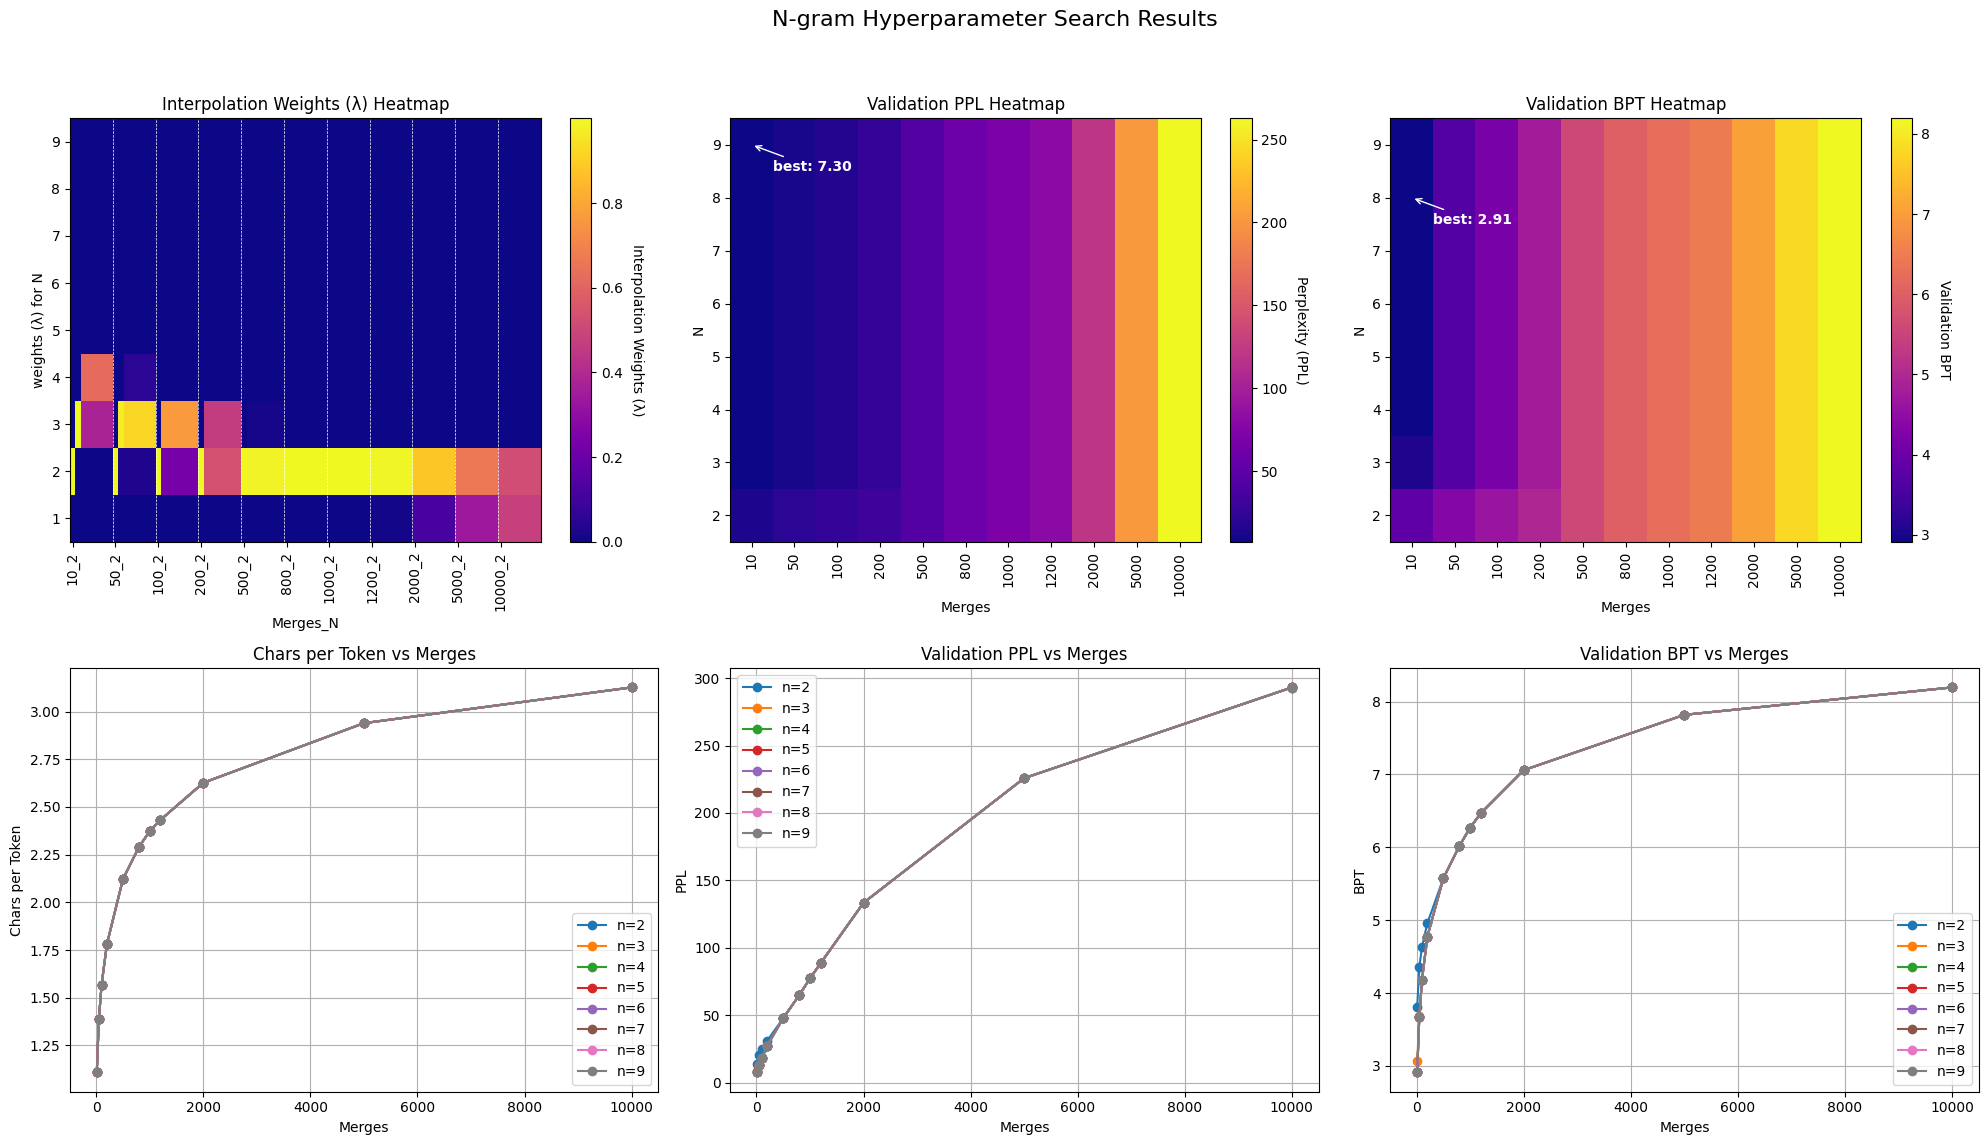

In [41]:
plot_parameter_search_results(df_ngram_fit_results, save_path=os.path.join(NGRAM_RESULTS_DIR, "ngram_hparams_fit_results.png"))

### fit metrics on test data

In [42]:
# run multiple models with different params and tokenizers on held out test data
def fit_ngram_to_test_data(train_file: str,
                           train_text: str,
                           val_text: str,
                           test_text: str,
                            merges: int,
                            n: int,
                            lambdas: list,):
        

    tokenizer = train_bytelevel_bpe(
        files=[train_file],
        merges=merges,
        min_frequency=2,
        lowercase=False,
        add_prefix_space=True,

    )

    # encode train and test sets
    train_ids = tokenizer.encode(train_text).ids
    test_ids = tokenizer.encode(test_text).ids
    val_ids = tokenizer.encode(val_text).ids



    model = NGramEngine(n)
    model.fit(train_ids,
            lambdas=lambdas, 
            pad_token=tokenizer.token_to_id(SPECIAL_TOKENS['bos']) if SPECIAL_TOKENS.get('bos', None) is not None else BOS_TOKEN_ID)


    fit_results_train = model.fit_metrics(train_ids, interpolate=True)
    fit_results_val = model.fit_metrics(val_ids, interpolate=True)
    fit_results_test = model.fit_metrics(test_ids, interpolate=True)

    # generate sample text
    context_text = " ".join(test_text.split()[:3])
    context_text_ids = tokenizer.encode(context_text, add_special_tokens=False).ids
    sample_text_ids = model.generate(
        context_text_ids,
        # max_new_tokens=100,
        max_new_tokens=100,
        mode="sample",
        temperature=0.9,
        top_k=20,
        top_p=None,
        repetition_penalty=0.95,
    )
    sample_text = tokenizer.decode(sample_text_ids)

    print(f"Test set metrics with best params (merges={merges}, n={n}):")
    print(f"lambdas: {lambdas}")
    print(f"train BPT: {fit_results_train['bpt']:.7f}, PPL: {fit_results_train['ppl']:.3f}")
    print(f"Validation BPT: {fit_results_val['bpt']:.7f}, PPL: {fit_results_val['ppl']:.3f}")
    print(f"Test BPT: {fit_results_test['bpt']:.7f}, PPL: {fit_results_test['ppl']:.3f}")
    print("\nSample text generated from the model:")
    print(f"Context: {context_text}")
    print("generated_text: ", sample_text)

    return {
        "tokenizer": tokenizer,
        "model": model,
        "fit_results_train": fit_results_train,
        "fit_results_val": fit_results_val,
        "fit_results_test": fit_results_test,
        "sample_text": sample_text,
        "context_text": context_text
    }

In [44]:
best_ppl_row = df_ngram_fit_results.loc[df_ngram_fit_results["val_ppl"].idxmin()]
best_merges = best_ppl_row["merges"]

# for each merge in n_merges_grid, fit tokenizer and then get the best n and lambdas from df_ngram_fit_results and fit the model
n_merges_grid = [200, 800] + [best_merges]
n_merges_grid = sorted(set(n_merges_grid)) 
all_test_results = []
for merges in n_merges_grid:
    tokenizer = train_bytelevel_bpe(
        files=[train_file],
        merges=merges,
        min_frequency=2,
        lowercase=False,
        add_prefix_space=True,
    )

    subset_df = df_ngram_fit_results[df_ngram_fit_results["merges"] == merges]
    if subset_df.empty:
        print(f"No results found for merges={merges}. Skipping.")
        continue
    best_ppl_row = subset_df.loc[subset_df["val_ppl"].idxmin()]
    best_n = best_ppl_row["n"]  
    best_lambdas = best_ppl_row["best_lambdas"]

    print("#" * 50) 
    if merges == best_merges:
        print(f"**(best fit)** for merges={merges}: results for best n {best_n} and lambdas {best_lambdas}:")
    print(f"for merges={merges}: results for best n {best_n} and lambdas {best_lambdas}:")

    res = fit_ngram_to_test_data(
        train_file=train_file,
        train_text=train_text,
        val_text=val_text,
        test_text=test_text,
        merges=merges,
        n=best_n,
        lambdas=best_lambdas
    )
    all_test_results.append({
        "merges": merges,
        "n": best_n,
        "lambdas": best_lambdas,
        **res
        })

##################################################
**(best fit)** for merges=10: results for best n 8 and lambdas [4.860967550781637e-13, 3.006354504068416e-08, 0.3774256261513804, 0.6225468920124947, 2.745177063555667e-05, 4.860967550781637e-13, 4.860967550781637e-13, 4.860967550781637e-13]:
for merges=10: results for best n 8 and lambdas [4.860967550781637e-13, 3.006354504068416e-08, 0.3774256261513804, 0.6225468920124947, 2.745177063555667e-05, 4.860967550781637e-13, 4.860967550781637e-13, 4.860967550781637e-13]:
Test set metrics with best params (merges=10, n=8):
lambdas: [4.860967550781637e-13, 3.006354504068416e-08, 0.3774256261513804, 0.6225468920124947, 2.745177063555667e-05, 4.860967550781637e-13, 4.860967550781637e-13, 4.860967550781637e-13]
train BPT: 2.8774334, PPL: 7.348
Validation BPT: 2.9180666, PPL: 7.558
Test BPT: 3.0048516, PPL: 8.027

Sample text generated from the model:
Context: loved you much;
generated_text:   loved you much;
And havenstains remeth of hat alse la

,merges,test_ppl,train_ppl,val_ppl,n,lambdas
0,10,8.027000,7.348000,7.558000,8,"0.000, 0.000, 0.377, 0.623, 0.000, 0.000, 0.000, 0.000"
1,200,29.887000,25.823000,27.450000,9,"0.000, 0.532, 0.468, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000"
2,800,71.070000,59.509000,64.977000,9,"0.000, 1.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000"


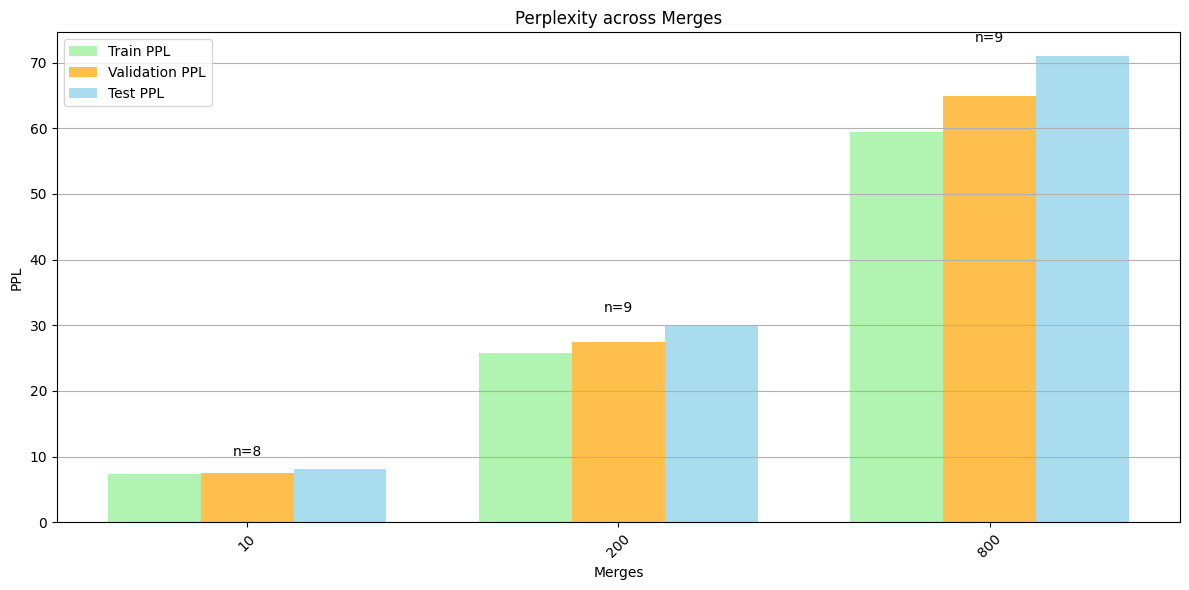


Generated sample texts for each model:
context: 
--  loved you much;

Generated sample text for merges=10, n=8, lambdas=[4.860967550781637e-13, 3.006354504068416e-08, 0.3774256261513804, 0.6225468920124947, 2.745177063555667e-05, 4.860967550781637e-13, 4.860967550781637e-13, 4.860967550781637e-13]:

--  loved you much;
And havenstains remeth of hat alse latine.

ANG Caest ive,
Where I shamp; and hat grefor a play live times:

------------------------------------------------------------------------------------------------------------------------

Generated sample text for merges=200, n=9, lambdas=[9.618432482653672e-12, 0.532084173212516, 0.46791034169393453, 5.475223925183116e-06, 9.499627287422589e-09, 3.1261000144060516e-10, 3.4471050363477524e-11, 9.2950950837516e-12, 4.002505757760598e-12]:

--  loved you much; Thenger of chastrue?

As VENTUS
AUDESSIO
GOSSAVIs nast

Thence.



ALIA
Exit


Orong.

ROMITRABut I







BAS

LINO
If it is the

-----------------------------------------

In [46]:
test_results_df = pd.DataFrame(all_test_results)
# pull nested metrics
df_tbl = pd.DataFrame({
    "merges": test_results_df["merges"],
    "test_ppl":  test_results_df["fit_results_test"].apply(lambda d: d["ppl"].round(3)),
    "train_ppl": test_results_df["fit_results_train"].apply(lambda d: d["ppl"].round(3)),
    "val_ppl":   test_results_df["fit_results_val"].apply(lambda d: d["ppl"].round(3)),
    "n":      test_results_df["n"],
    "lambdas": test_results_df["lambdas"],
})

df_tbl = df_tbl.sort_values(["test_ppl", "val_ppl", "train_ppl"], ascending=True).reset_index(drop=True)
df_tbl["lambdas"] = df_tbl["lambdas"].apply(lambda x: [round(v, 4) for v in x])  # round lambdas to 3 decimal places
# display full table, no turning off truncation
display(df_tbl.style
    .set_properties(**{'text-align': 'left'})
    .set_table_styles([{
        'selector': 'th',
        'props': [('text-align', 'left')]
    }])
    .format({
        "lambdas": lambda x: ', '.join(f"{v:.3f}" for v in x)
    })
)
# Extract metrics
train_ppl = test_results_df["fit_results_train"].apply(lambda x: x["ppl"])
val_ppl   = test_results_df["fit_results_val"].apply(lambda x: x["ppl"])
test_ppl  = test_results_df["fit_results_test"].apply(lambda x: x["ppl"])
merges    = test_results_df["merges"].values
n_vals    = test_results_df["n"].values

# Grouped bar positions
x = np.arange(len(merges))   # one x per merge setting
width = 0.25                 # bar width

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width, train_ppl, width, label="Train PPL", color="lightgreen", alpha=0.7)
ax.bar(x,         val_ppl,   width, label="Validation PPL", color="orange", alpha=0.7)
ax.bar(x + width, test_ppl,  width, label="Test PPL", color="skyblue", alpha=0.7)

# annotate with n
for i, (xp, y) in enumerate(zip(x, test_ppl)):
    ax.annotate(f"n={n_vals[i]}", (xp, y), textcoords="offset points", xytext=(0,10),
                ha='center', fontsize=10)

ax.set_xticks(x)
ax.set_xticklabels(merges, rotation=45)
ax.set_title("Perplexity across Merges")
ax.set_xlabel("Merges")
ax.set_ylabel("PPL")
ax.grid(True, axis='y')
ax.legend()
plt.tight_layout()
plt.show()

# print the generated sample text for the best model
print("\nGenerated sample texts for each model:")
print("context: \n-- ", all_test_results[0]["context_text"])
for res in all_test_results:
    print(f"\nGenerated sample text for merges={res['merges']}, n={res['n']}, lambdas={res['lambdas']}:")
    print(f"\n-- {res['sample_text']}\n")
    print('-' * 120)


# save table, plot, and written results
os.makedirs(NGRAM_RESULTS_DIR, exist_ok=True)
df_tbl.to_csv(os.path.join(NGRAM_RESULTS_DIR, "ngram_test_results.csv"), index=False)
# save the plot of PPL across merges
fig.savefig(os.path.join(NGRAM_RESULTS_DIR, "ngram_test_results_ppl.png"), bbox_inches='tight')
# save the generated sample texts to a text file
with open(os.path.join(NGRAM_RESULTS_DIR, "ngram_generated_samples.txt"), "w", encoding="utf-8") as f:
    for res in all_test_results:
        f.write(f"Generated sample text for merges={res['merges']}, n={res['n']}, lambdas={res['lambdas']}:\n")
        f.write(f"\n-- {res['sample_text']}\n")
        f.write('-' * 120 + '\n')
    f.write("\nContext for generated samples:\n")
    f.write(f"-- {all_test_results[0]['context_text']}\n")

print(f"Results saved to {NGRAM_RESULTS_DIR}")